In [3]:
files =  "/home/sai/Desktop/arc/ARC-AGI/data/training"
import numpy as np
from functools import reduce
from collections import namedtuple
from typing import List, Tuple, Union

MAXSIDE = 100
MAXAREA = 40 * 40
MAXPIXELS = 40 * 40 * 5

import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src', 'arclang')))
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from image import Image, Point
from function import *

In [4]:
import random


def random_image(width, height):
    img = Image.empty(0, 0, width, height)
    for i in range(height):
        for j in range(width):
            img.mask[i, j] = random.randint(0, 9)
    return img

def apply_stacked_transformations(img, num_stacks=3, transforms_per_stack=2):
    transformations = [
        lambda x: mirror(x, Image.full(Point(0, 0), Point(x.w, x.h))),
        lambda x: filter_col(x, random_image(1, 1)),
        lambda x: compose(x, random_image(x.w, x.h), lambda a, b: max(a, b), random.choice([0, 1])),
        lambda x: smear(x, random_image(x.w, x.h), random.randint(0, 6)),
        lambda x: cut_pick_max(x, random_image(x.w, x.h), random.randint(0, 13)),
        lambda x: extend(x, Image.full(Point(0, 0), Point(x.w + 2, x.h + 2))),
        lambda x: compress(x),
        lambda x: interior(x),
        lambda x: border(x),
        lambda x: connect(x, random.randint(0, 2)),
        lambda x: replace_cols(x, random_image(x.w, x.h)),
        lambda x: center(x),
        lambda x: rigid(x, random.randint(0, 8)),
        lambda x: invert(x),
        lambda x: compose_growing(split_all(x)),
        lambda x: align(x, random_image(x.w, x.h), random.randint(0, 5), random.randint(0, 5)),
        lambda x: get_regular(x),
        lambda x: get_alternating(x),
        lambda x: get_constant(x),
        lambda x: get_repeating(x),
        lambda x: heuristic_cut(x),
        lambda x: my_stack(x, random_image(x.w, x.h), random.randint(0, 3)),
        lambda x: wrap(x, Image.full(Point(0, 0), Point(x.w, x.h))),
        lambda x: gravity(x, random.randint(0, 3))[0]  # Taking the first element as gravity returns a list
    ]
    
    for _ in range(num_stacks):
        stack = compose_list([random.choice(transformations)(img) for _ in range(transforms_per_stack)], 0)
        img = stack if stack.w > 0 and stack.h > 0 else img  # Ensure we don't end up with an empty image
    
    return img

def generate_synthetic_data(num_examples=5, min_size=5, max_size=20):
    data = {"train": []}
    
    for _ in range(num_examples):
        width = random.randint(min_size, max_size)
        height = random.randint(min_size, max_size)
        
        input_img = random_image(width, height)
        transformed_img = apply_stacked_transformations(input_img)
        
        input_data = input_img.mask.tolist()
        output_data = transformed_img.mask.tolist()
        
        data["train"].append({
            "input": input_data,
            "output": output_data
        })
    
    return data

def post_process(data, output_width=3):
    for example in data["train"]:
        input_height = len(example["input"])
        example["output"] = [[0 for _ in range(output_width)] for _ in range(input_height)]
        
        for i in range(input_height):
            for j in range(output_width):
                if j < len(example["input"][i]):
                    if example["input"][i][j] != 0:
                        example["output"][i][j] = 8
                    elif random.random() < 0.1:  # 10% chance of a non-zero output for zero input
                        example["output"][i][j] = random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9])

    return data

# # Generate and post-process synthetic data
# synthetic_data = generate_synthetic_data(num_examples=10)
# processed_data = post_process(synthetic_data)
# print(json.dumps(processed_data, indent=2))

In [5]:
import random
import json 
def create_basic_shape(size=3):
    shapes = [
        lambda: Image.full(Point(0, 0), Point(size, size), random.randint(1, 9)),
        lambda: Image.full(Point(0, 0), Point(size, 1), random.randint(1, 9)),
        lambda: Image.full(Point(0, 0), Point(1, size), random.randint(1, 9)),
        lambda: Image.full(Point(0, 0), Point(size, size), 0)
    ]
    return random.choice(shapes)()

def create_pattern(size=5):
    base = create_basic_shape(3)
    pattern = repeat(base, Image.full(Point(0, 0), Point(size, size)))
    return pattern

def combine_patterns(patterns, size):
    combined = Image.empty(0, 0, size, size)
    for pattern in patterns:
        combined = compose(combined, pattern, lambda x, y: max(x, y), 0)
    return combined

def apply_transformations(img):
    transformations = [
        lambda x: mirror(x, Image.full(Point(0, 0), Point(x.w, x.h))),
        lambda x: compose(x, create_pattern(x.w), lambda a, b: max(a, b), 0),
        lambda x: cut_pick_max(x, create_pattern(x.w), random.randint(0, 13)),
        lambda x: connect(x, random.randint(0, 2))
    ]
    
    for _ in range(random.randint(1, 3)):
        transform = random.choice(transformations)
        img = transform(img)
    
    return img

def generate_synthetic_data(num_examples=5, min_size=10, max_size=30):
    data = {"train": []}
    
    for _ in range(num_examples):
        size = random.randint(min_size, max_size)
        num_patterns = random.randint(2, 5)
        
        patterns = [create_pattern(size // 2) for _ in range(num_patterns)]
        input_img = combine_patterns(patterns, size)
        transformed_img = apply_transformations(input_img)
        
        input_data = input_img.mask.tolist()
        output_data = transformed_img.mask.tolist()
        
        data["train"].append({
            "input": input_data,
            "output": output_data
        })
    
    return data

def post_process(data, output_width=3):
    for example in data["train"]:
        input_height = len(example["input"])
        example["output"] = [[0 for _ in range(output_width)] for _ in range(input_height)]
        
        for i in range(input_height):
            for j in range(output_width):
                if j < len(example["input"][i]):
                    if example["input"][i][j] != 0:
                        example["output"][i][j] = 8
                    elif random.random() < 0.05:  # 5% chance of a non-zero output for zero input
                        example["output"][i][j] = random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9])

    return data

# Generate and post-process synthetic data
synthetic_data = generate_synthetic_data(num_examples=100)
processed_data = post_process(synthetic_data)
# print(json.dumps(processed_data, indent=2))

In [6]:
# processed_data

In [7]:
# path = "/home/sai/Desktop/arc/ARC-AGI/data/training/0b148d64.json"
# with open(path,"r") as f:
#     data_ce9 = json.loads(f.read())


In [8]:
processed_data["train"][0]["input"]

[[6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [6,
  6,
  6

In [9]:
def create_image(img_mask):
    
    img_mask = np.array(img_mask)
    y,x = img_mask.shape
    input_img= Image(0,0,x,y,img_mask)
    display_matrix(input_img)

In [10]:
import random

def create_basic_shape(size=3):
    shapes = [
        lambda: Image.full(Point(0, 0), Point(size, size), random.randint(1, 9)),
        lambda: Image.full(Point(0, 0), Point(size, 1), random.randint(1, 9)),
        lambda: Image.full(Point(0, 0), Point(1, size), random.randint(1, 9)),
        lambda: Image.full(Point(0, 0), Point(size, size), 0),
        lambda: Image.empty(0, 0, size, size),  # Empty shape for more varied patterns
    ]
    shape = random.choice(shapes)()
    
    # Randomly add some pixels to create more varied basic shapes
    for _ in range(random.randint(0, size * 2)):
        x, y = random.randint(0, size - 1), random.randint(0, size - 1)
        shape.mask[y, x] = random.randint(1, 9)
    
    return shape

def create_pattern(size=5):
    base = create_basic_shape(random.randint(2, 4))
    pattern = repeat(base, Image.full(Point(0, 0), Point(size, size)))
    
    # Randomly apply some transformations to the pattern
    transformations = [
        lambda x: mirror(x, Image.full(Point(0, 0), Point(x.w, x.h))),
        lambda x: rigid(x, random.randint(0, 7)),
        lambda x: connect(x, random.randint(0, 2)),
        lambda x: invert(x),
    ]
    
    for _ in range(random.randint(1, 3)):
        transform = random.choice(transformations)
        pattern = transform(pattern)
    
    return pattern

def combine_patterns(patterns, size):
    combined = Image.empty(0, 0, size, size)
    for pattern in patterns:
        # Randomly choose how to combine patterns
        combine_method = random.choice([
            lambda x, y: compose(x, y, lambda a, b: max(a, b), 0),
            lambda x, y: compose(x, y, lambda a, b: min(a, b) if a != 0 and b != 0 else max(a, b), 0),
            lambda x, y: compose_id(x, y, random.randint(0, 4))
        ])
        combined = combine_method(combined, pattern)
    return combined

def apply_transformations(img):
    transformations = [
        lambda x: mirror(x, Image.full(Point(0, 0), Point(x.w, x.h))),
        lambda x: compose(x, create_pattern(x.w), lambda a, b: max(a, b), 0),
        lambda x: cut_pick_max(x, create_pattern(x.w), random.randint(0, 13)),
        lambda x: connect(x, random.randint(0, 2)),
        lambda x: rigid(x, random.randint(0, 7)),
        lambda x: invert(x),
        lambda x: border(x),
        lambda x: interior(x),
        lambda x: smear(x, create_pattern(x.w), random.randint(0, 6)),
    ]
    
    for _ in range(random.randint(1, 4)):
        transform = random.choice(transformations)
        img = transform(img)
    
    return img

def generate_synthetic_data(num_examples=5, min_size=10, max_size=30):
    data = {"train": []}
    
    for _ in range(num_examples):
        size = random.randint(min_size, max_size)
        num_patterns = random.randint(2, 5)
        
        patterns = [create_pattern(random.randint(size // 4, size // 2)) for _ in range(num_patterns)]
        input_img = combine_patterns(patterns, size)
        transformed_img = apply_transformations(input_img)
        
        input_data = input_img.mask.tolist()
        output_data = transformed_img.mask.tolist()
        
        data["train"].append({
            "input": input_data,
            "output": output_data
        })
    
    return data

def post_process(data, output_width=3):
    for example in data["train"]:
        input_height = len(example["input"])
        example["output"] = [[0 for _ in range(output_width)] for _ in range(input_height)]
        
        for i in range(input_height):
            for j in range(output_width):
                if j < len(example["input"][i]):
                    if example["input"][i][j] != 0:
                        example["output"][i][j] = 8
                    elif random.random() < 0.05:  # 5% chance of a non-zero output for zero input
                        example["output"][i][j] = random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9])

    return data

# # Generate and post-process synthetic data
# synthetic_data = generate_synthetic_data(num_examples=10)
# processed_data = post_process(synthetic_data)
# print(json.dumps(processed_data, indent=2))

In [ ]:
np.random.normal()

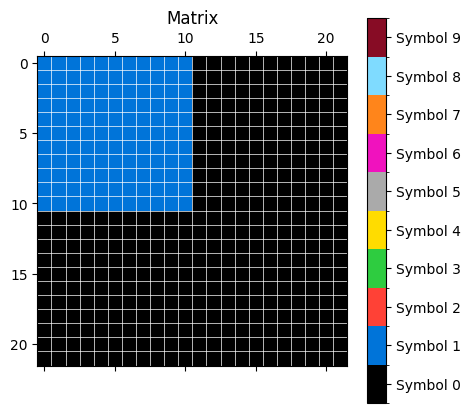

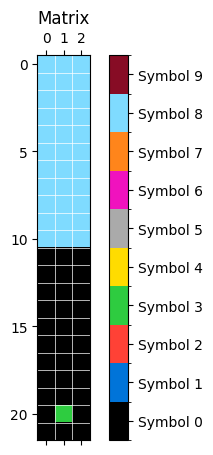

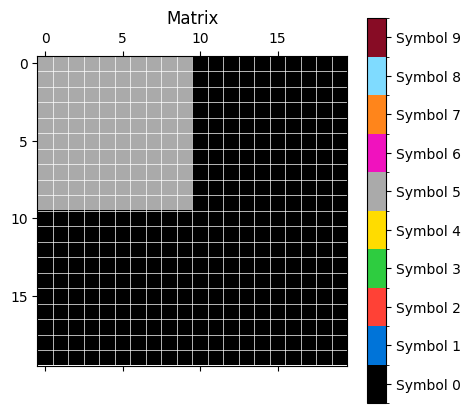

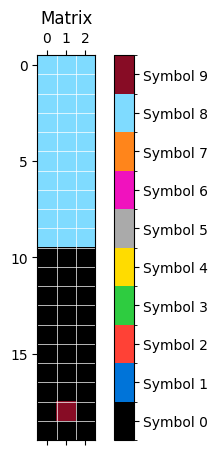

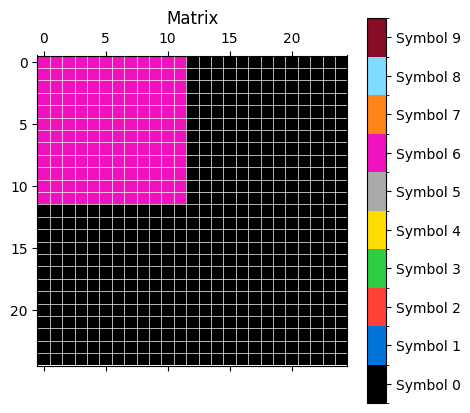

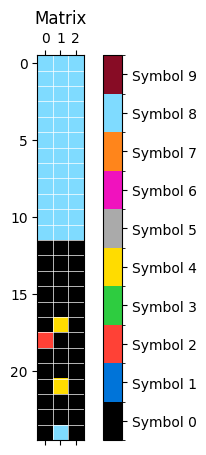

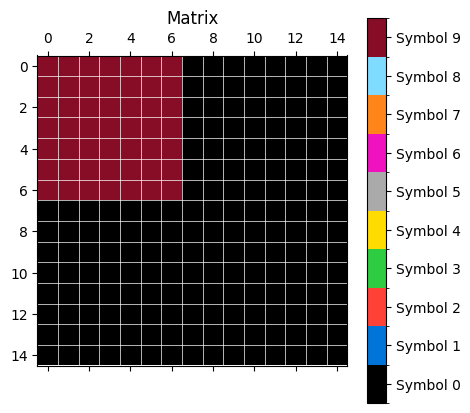

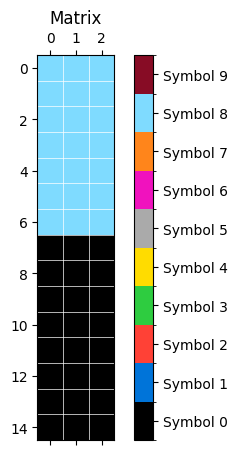

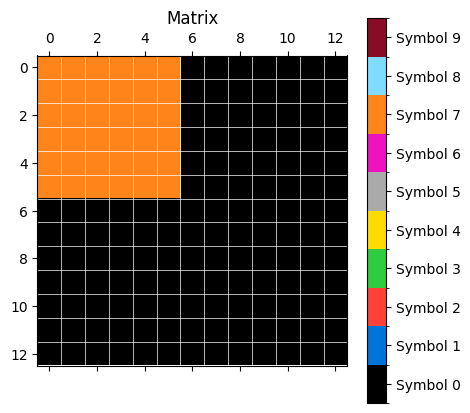

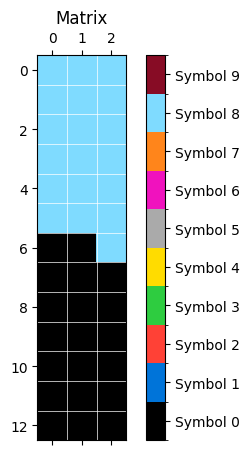

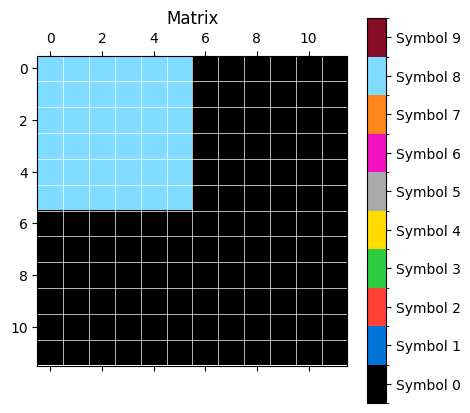

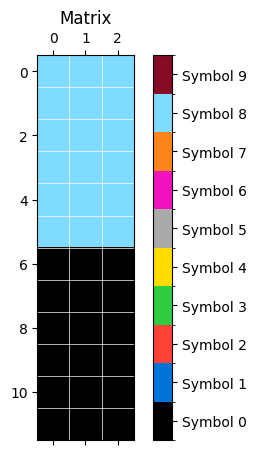

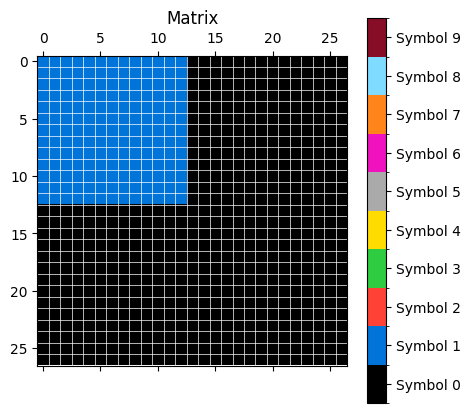

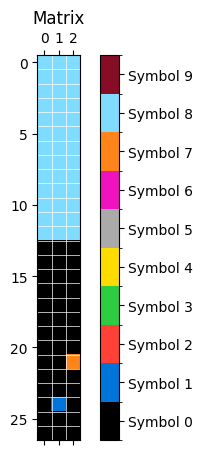

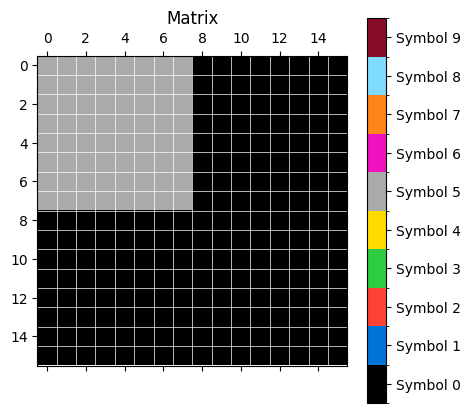

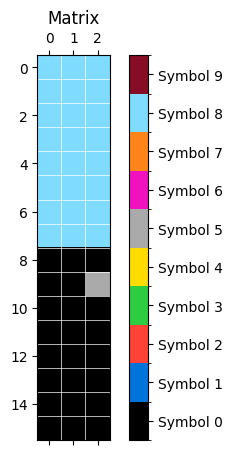

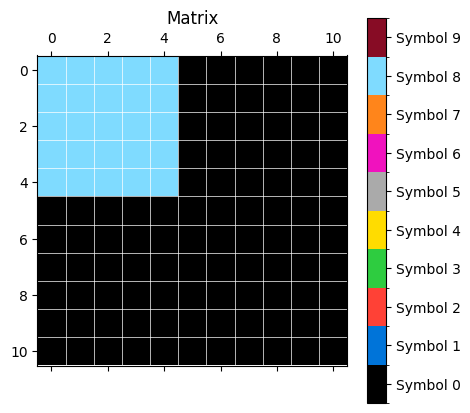

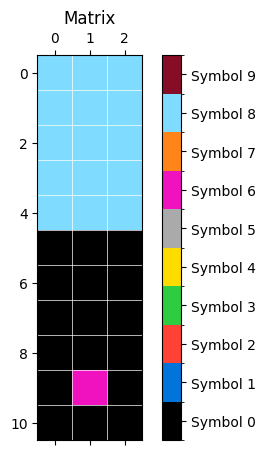

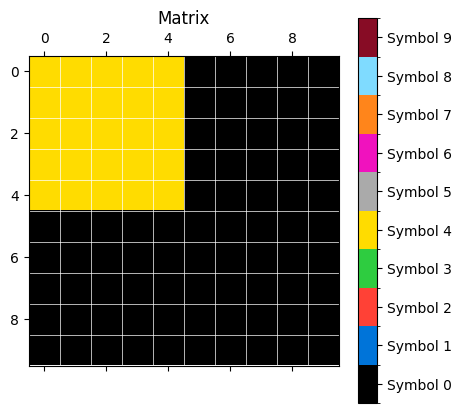

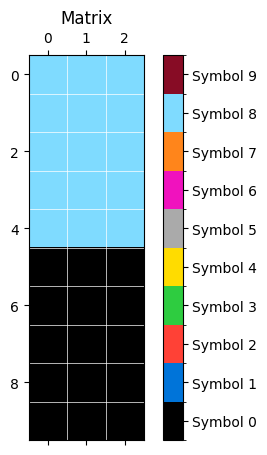

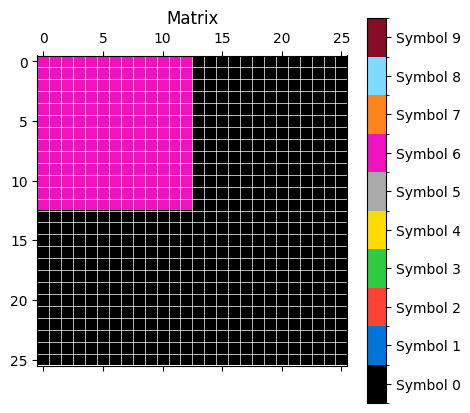

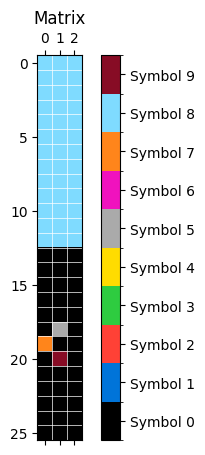

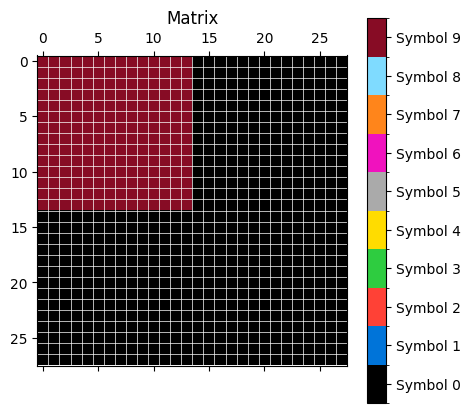

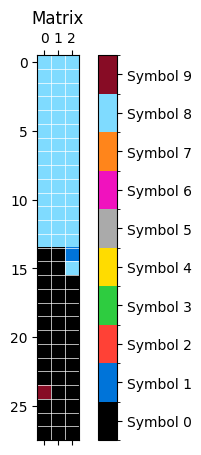

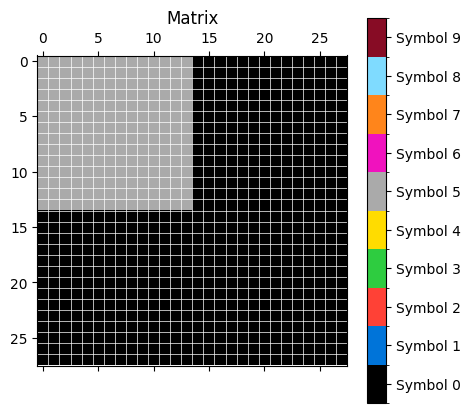

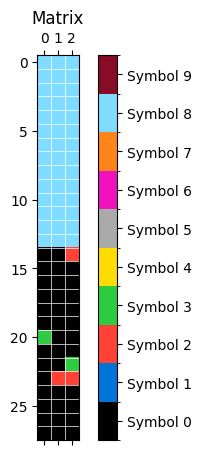

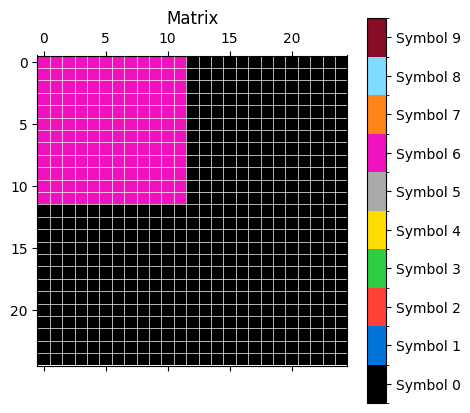

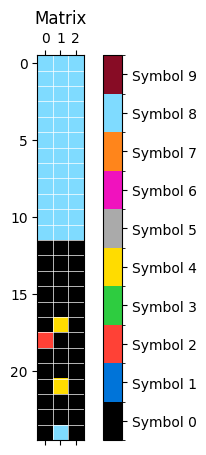

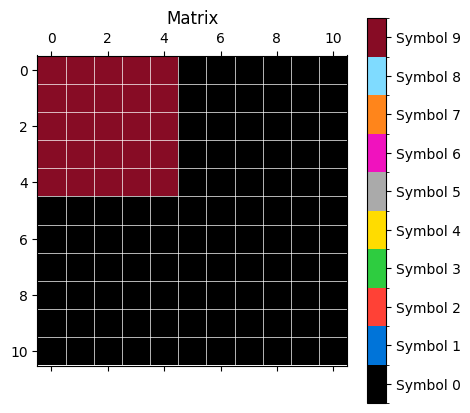

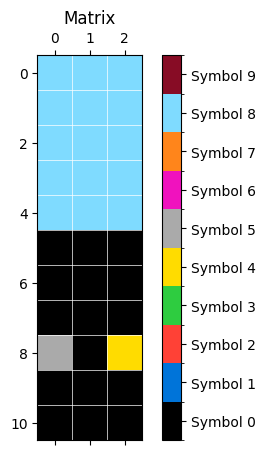

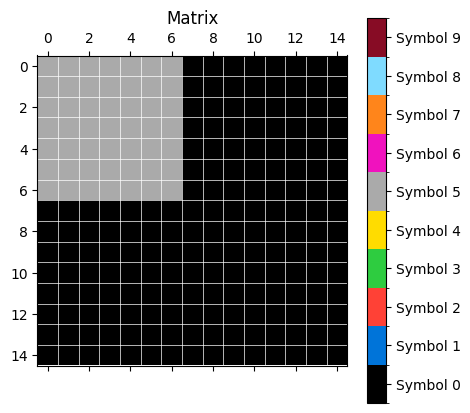

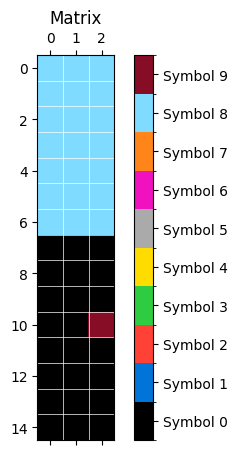

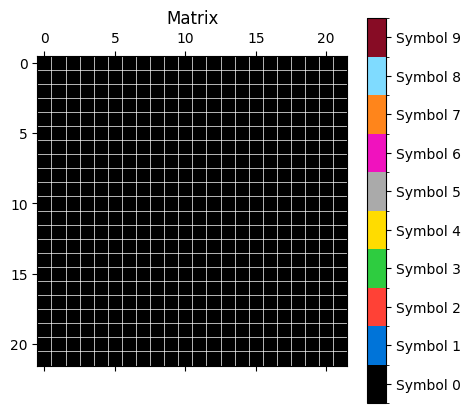

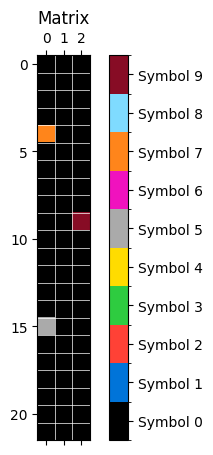

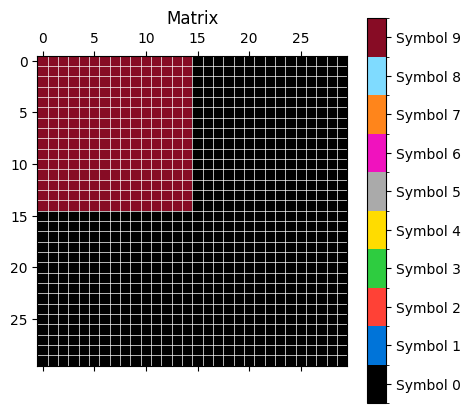

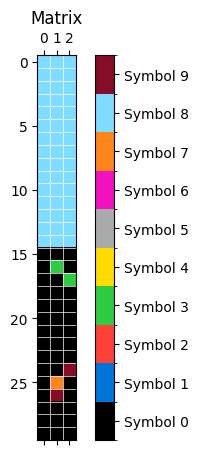

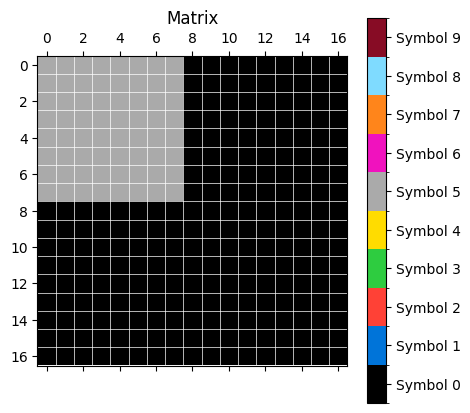

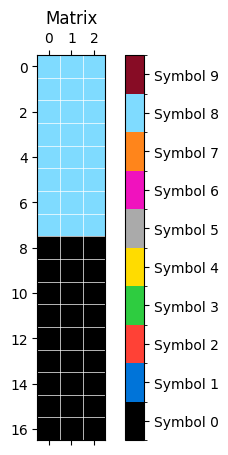

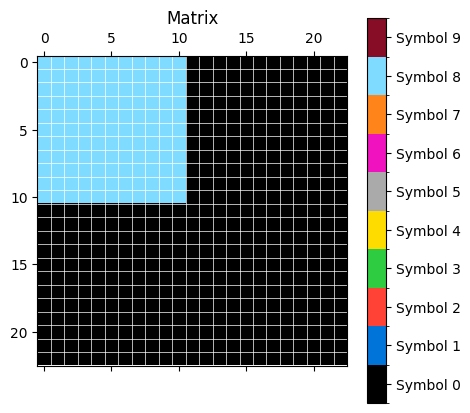

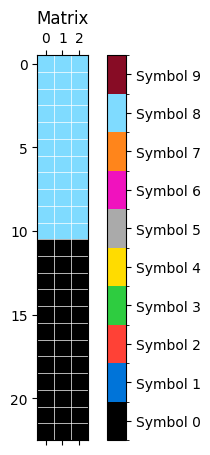

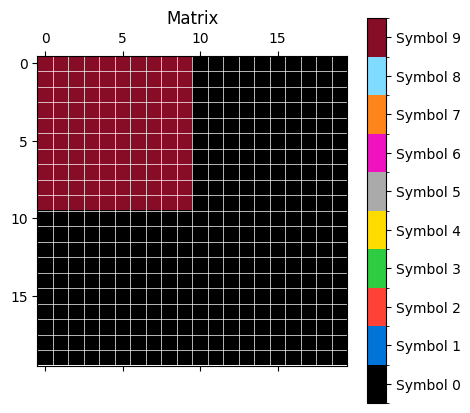

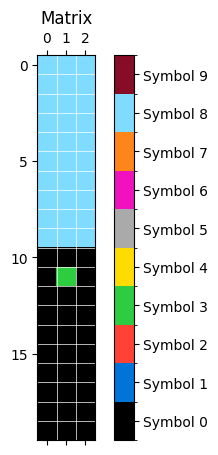

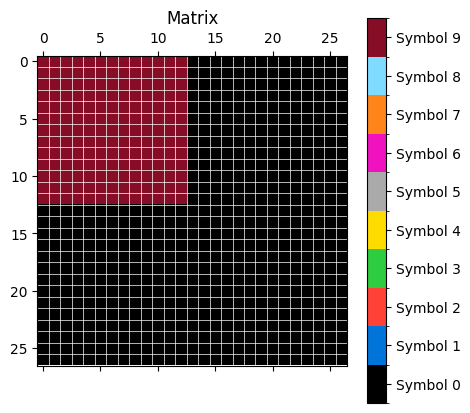

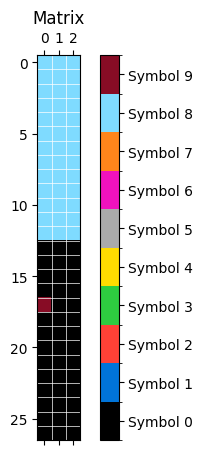

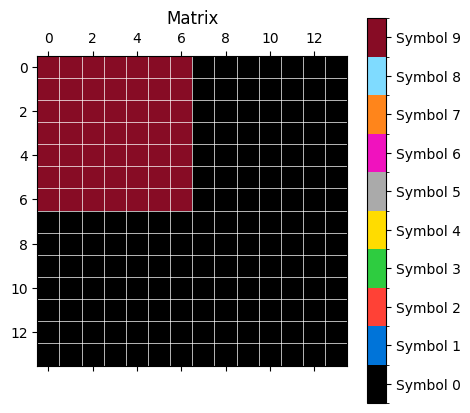

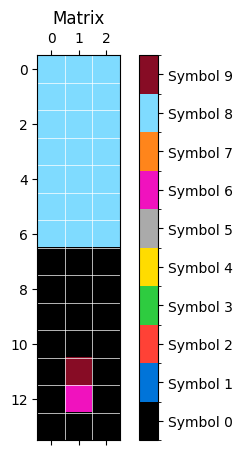

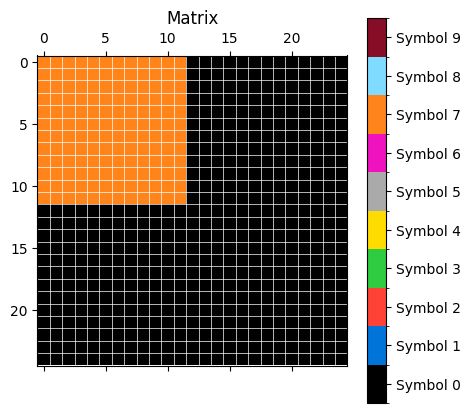

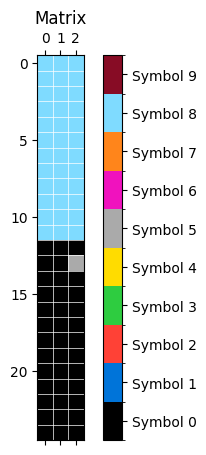

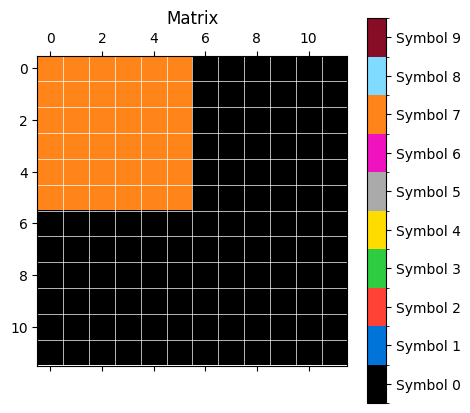

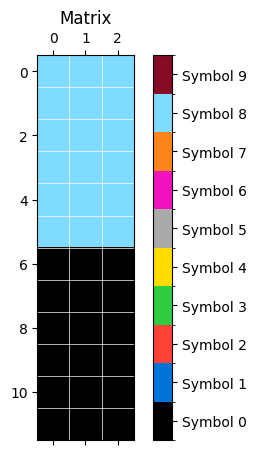

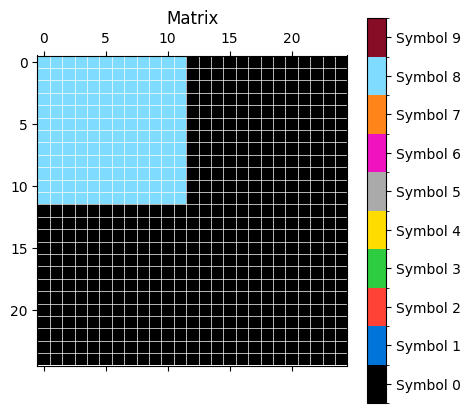

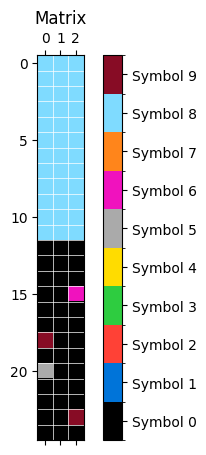

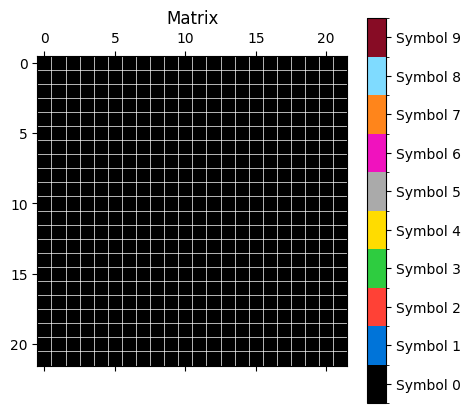

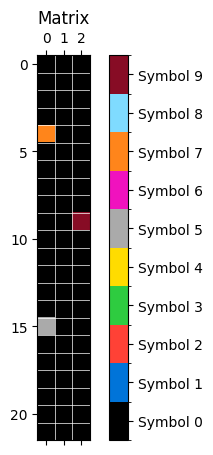

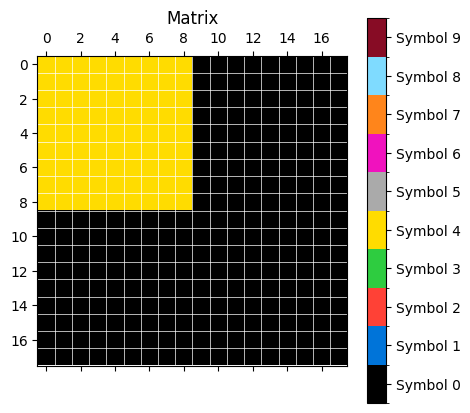

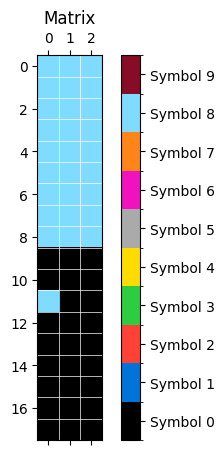

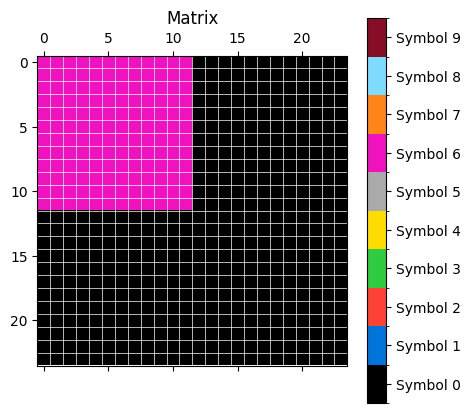

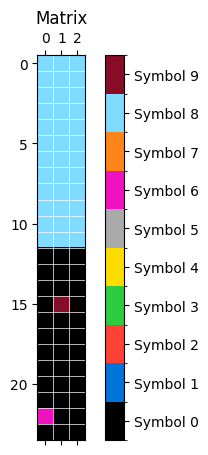

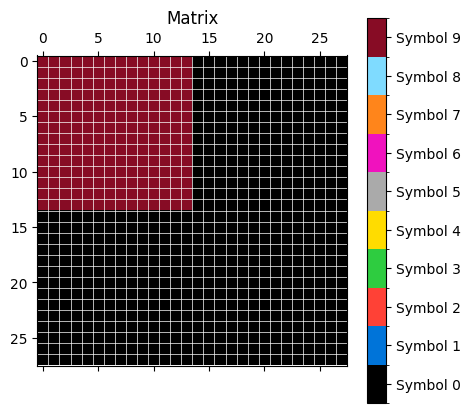

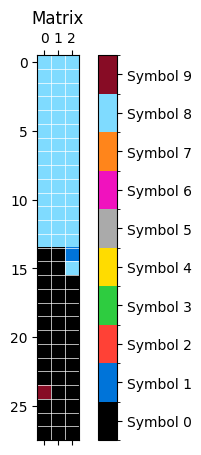

In [11]:
for _ in range(30):
    v= np.random.choice(processed_data["train"])
    img_mask = v["input"]
    create_image(img_mask)
    img_mask = v["output"]
    create_image(img_mask)


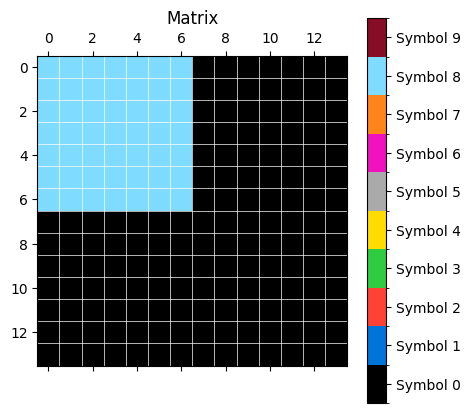

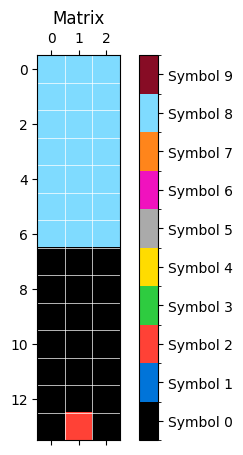

In [48]:
img_mask = v["input"]
create_image(img_mask)
img_mask = v["output"]
create_image(img_mask)


In [7]:
import random

def create_small_random_shape(size=3):
    img = Image.empty(0, 0, size, size)
    for i in range(size):
        for j in range(size):
            if random.random() < 0.5:  # 50% chance of a non-zero pixel
                img.mask[i, j] = random.randint(1, 9)
    return img

def create_medium_shape(size=5):
    shapes = [
        lambda: Image.full(Point(0, 0), Point(size, size), random.randint(1, 9)),
        lambda: Image.full(Point(0, 0), Point(size, 1), random.randint(1, 9)),
        lambda: Image.full(Point(0, 0), Point(1, size), random.randint(1, 9)),
        lambda: Image.empty(0, 0, size, size),
    ]
    shape = random.choice(shapes)()
    
    # Add some random pixels
    for _ in range(size * 2):
        x, y = random.randint(0, size - 1), random.randint(0, size - 1)
        shape.mask[y, x] = random.randint(1, 9)
    
    return shape

def create_large_structured_shape(size=7):
    base = create_medium_shape(size // 2)
    pattern = repeat(base, Image.full(Point(0, 0), Point(size, size)))
    
    transformations = [
        lambda x: mirror(x, Image.full(Point(0, 0), Point(x.w, x.h))),
        lambda x: rigid(x, random.randint(0, 7)),
        lambda x: connect(x, random.randint(0, 2)),
    ]
    
    for transform in random.sample(transformations, k=2):
        pattern = transform(pattern)
    
    return pattern

def create_size_appropriate_shape(size):
    if size <= 3:
        return create_small_random_shape(size)
    elif size <= 6:
        return create_medium_shape(size)
    else:
        return create_large_structured_shape(size)

def combine_shapes(shapes):
    if not shapes:
        return Image.empty(0, 0, 1, 1)
    
    combined = shapes[0]
    for shape in shapes[1:]:
        combined = compose(combined, shape, lambda a, b: max(a, b), 0)
    return combined

def apply_transformations(img):
    transformations = [
        lambda x: mirror(x, Image.full(Point(0, 0), Point(x.w, x.h))),
        lambda x: cut_pick_max(x, create_size_appropriate_shape(x.w // 2), random.randint(0, 13)),
        lambda x: connect(x, random.randint(0, 2)),
        lambda x: rigid(x, random.randint(0, 7)),
        lambda x: invert(x),
        lambda x: border(x),
        lambda x: interior(x),
    ]
    
    for _ in range(random.randint(1, 3)):
        transform = random.choice(transformations)
        img = transform(img)
    
    return img

def generate_synthetic_data(num_examples=5, min_size=3, max_size=30):
    data = {"train": []}
    
    for _ in range(num_examples):
        size = random.randint(min_size, max_size)
        num_shapes = random.randint(1, max(2, size // 3))
        
        shapes = [create_size_appropriate_shape(random.randint(min_size, size)) for _ in range(num_shapes)]
        input_img = combine_shapes(shapes)
        
        # Ensure the final image size matches the intended size
        if input_img.w < size or input_img.h < size:
            background = Image.empty(0, 0, size, size)
            input_img = compose(background, input_img, lambda a, b: max(a, b), 0)
        elif input_img.w > size or input_img.h > size:
            input_img = input_img.sub_image(Point(0, 0), Point(size, size))
        
        transformed_img = apply_transformations(input_img)
        
        input_data = input_img.mask.tolist()
        output_data = transformed_img.mask.tolist()
        
        data["train"].append({
            "input": input_data,
            "output": output_data
        })
    
    return data

def post_process(data, output_width=3):
    for example in data["train"]:
        input_height = len(example["input"])
        example["output"] = [[0 for _ in range(output_width)] for _ in range(input_height)]
        
        for i in range(input_height):
            for j in range(output_width):
                if j < len(example["input"][i]):
                    if example["input"][i][j] != 0:
                        example["output"][i][j] = 8
                    elif random.random() < 0.05:  # 5% chance of a non-zero output for zero input
                        example["output"][i][j] = random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9])

    return data

# Generate and post-process synthetic data
synthetic_data = generate_synthetic_data(num_examples=10, min_size=3, max_size=30)
processed_data = post_process(synthetic_data)
# print(json.dumps(processed_data, indent=2))

NameError: name 'Image' is not defined

In [2]:
img_mask = v["input"]
create_image(img_mask)
img_mask = v["output"]
create_image(img_mask)


NameError: name 'v' is not defined

In [ ]:
img_mask = processed_data["train"][5]["input"]
img_mask = np.array(img_mask)
y,x = img_mask.shape
input_img= Image(0,0,x,y,img_mask)
display_matrix(input_img)

AttributeError: 'list' object has no attribute 'mask'

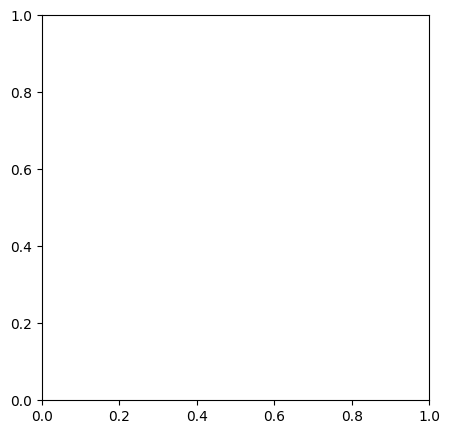

In [20]:
display_matrix(processed_data["train"])

In [ ]:
#

## Syntheic sizes required

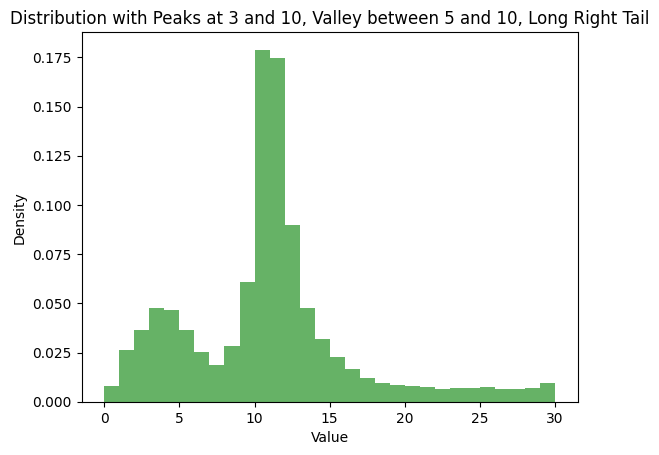

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the two normal distributions
mean1, std1, size1 = 3, 2, 10000  # Peak at 3
mean2, std2, size2 = 10, 1, 10000  # Peak at 10

# Generating the two normal distributions
data1 = np.random.normal(mean1, std1, size1)
data2 = np.random.normal(mean2, std2, size2)

data4 = np.random.uniform(14, 30, 5000)

# Parameters for the uniform distribution (for the valley)
valley_size = int((size1 + size2) * 0.20)  # 5% of the total peak size
data_valley = np.random.uniform(3, 10, valley_size)

# Parameters for the exponential distribution (for the long tail)
shape, scale, size3 = 1, 2, 20000
data3 = np.random.gamma(shape, scale, size3) + 10  # Shifting the gamma distribution

# Combining the data
combined_data = np.concatenate([data1, data2, data_valley, data3,data4])

# Trimming the data to fit within the desired range (0 to 30)
combined_data = np.round(combined_data[(combined_data >= 0) & (combined_data <= 30)])

# Plotting the combined distribution
plt.hist(np.round(combined_data), bins=30, density=True, alpha=0.6, color='g')
plt.title('Distribution with Peaks at 3 and 10, Valley between 5 and 10, Long Right Tail')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


In [49]:
from collections import Counter
Counter([np.random.choice(combined_data) for i in range(100000)])

Counter({10.0: 17776,
         11.0: 17454,
         12.0: 9233,
         9.0: 6159,
         3.0: 4794,
         13.0: 4699,
         4.0: 4665,
         2.0: 3697,
         5.0: 3612,
         14.0: 3138,
         8.0: 2780,
         1.0: 2547,
         6.0: 2454,
         15.0: 2353,
         7.0: 1905,
         16.0: 1642,
         17.0: 1214,
         18.0: 918,
         19.0: 849,
         21.0: 838,
         0.0: 824,
         20.0: 778,
         25.0: 738,
         24.0: 711,
         23.0: 684,
         22.0: 671,
         27.0: 666,
         28.0: 644,
         29.0: 633,
         26.0: 593,
         30.0: 331})

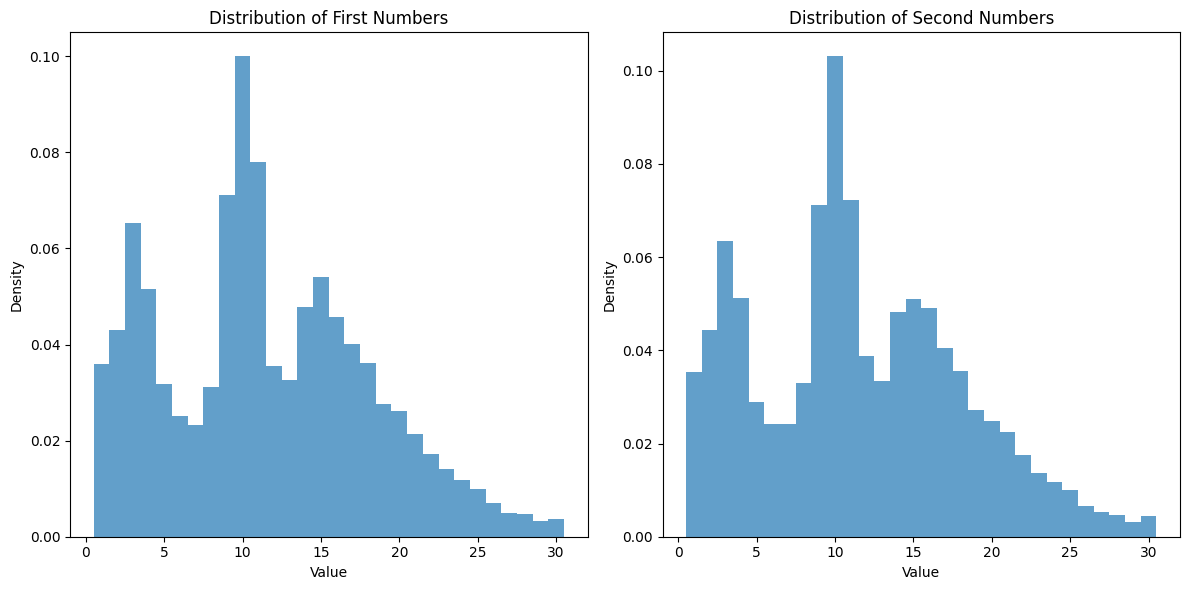

Sample number pairs (first, second):
(10, 7)
(17, 17)
(17, 11)
(3, 1)
(13, 13)
(10, 10)
(17, 17)
(10, 10)
(11, 11)
(11, 9)


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for the two normal distributions
mean1, std1, size1 = 3, 1, 10000  # Peak at 3
mean2, std2, size2 = 10, 0.8, 15000  # Peak at 10

# Generating the two normal distributions
data1 = np.random.normal(mean1, std1, size1)
data2 = np.random.normal(mean2, std2, size2)

# Parameters for the uniform distribution (for the valley)
valley_size = int((size1 + size2) * 0.1)  # 10% of the total peak size
data_valley = np.random.uniform(5, 8, valley_size)

# Parameters for the gamma distribution (for the long tail)
shape, scale = 2, 3
size3 = 20000
data3 = np.random.gamma(shape, scale, size3) + 12  # Shifting the gamma distribution

# Combining the data
combined_data = np.concatenate([data1, data2, data_valley, data3])

# Trimming the data to fit within the desired range (0 to 30)
combined_data = combined_data[(combined_data >= 0) & (combined_data <= 30)]

# Create a kernel density estimate
kde = stats.gaussian_kde(combined_data)

def generate_two_numbers():
    # Generate the first number from our distribution
    first_number = int(np.round(kde.resample(1)[0][0]))
    
    # Ensure the first number is between 1 and 30
    first_number = max(1, min(30, first_number))
    
    # Generate the second number
    if np.random.random() < 2/3:
        # 2/3 of the time, use the same number
        second_number = first_number
    else:
        # 1/3 of the time, add/subtract a scaled value from a normal distribution
        delta = int(np.round(np.random.normal(0, 1) * 5))  # Scale by 5 to get a range of roughly -10 to 10
        second_number = first_number + delta
    
    # Ensure the second number is also between 1 and 30
    second_number = max(1, min(30, second_number))
    if np.random.random()<=0.5:
        return first_number, second_number
return first_number, second_number

# Generate a sample of number pairs
sample_size = 10000
samples = [generate_two_numbers() for _ in range(sample_size)]

# Separate the samples into first and second numbers
first_numbers, second_numbers = zip(*samples)

# Plot the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(first_numbers, bins=30, range=(0.5, 30.5), density=True, alpha=0.7)
plt.title('Distribution of First Numbers')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(second_numbers, bins=30, range=(0.5, 30.5), density=True, alpha=0.7)
plt.title('Distribution of Second Numbers')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Print some sample pairs
print("Sample number pairs (first, second):")
for _ in range(10):
    print(generate_two_numbers())

(array([3.900e+01, 2.610e+02, 1.042e+03, 2.460e+03, 3.130e+03, 2.055e+03,
        8.460e+02, 1.530e+02, 1.200e+01, 2.000e+00]),
 array([-18. , -13.9,  -9.8,  -5.7,  -1.6,   2.5,   6.6,  10.7,  14.8,
         18.9,  23. ]),
 <BarContainer object of 10 artists>)

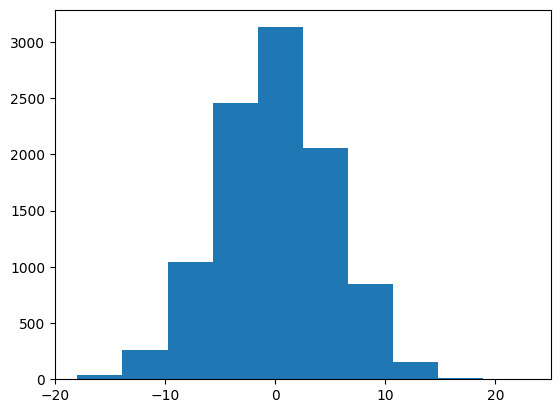

In [55]:
plt.hist([int(np.round(np.random.normal(0, 1) * 5)) for _ in range(10000)])